In [18]:
## Source: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Embedding, Input, Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import LSTM, Activation, Dropout
from keras.optimizers import RMSprop
from gensim.models import Word2Vec

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime

MAX_NB_WORDS = 22500
MAX_NB_WORDS = 6000
MAX_SEQUENCE_LENGTH = 1108
MAX_SEQUENCE_LENGTH = 1586
VALIDATION_SPLIT = 0.25



## Import the data

In [12]:
df = pd.read_csv('docs.csv').sample(frac=1).reset_index(drop=True)
df['date'] = df['rated'].apply(lambda x: datetime.datetime.strptime(x[:19],"%Y-%m-%d %H:%M:%S"))
df = df[df['date'] > datetime.datetime(2018,6,1,0,0,0)].reset_index(drop=True)

df.head()

## Extracting sus sentence:
from nltk.tokenize import sent_tokenize
def extract_sus(row):
    if "sustainab" in row['title'].lower():
        return row["title"]
    elif "sustainab" in row["content"].lower():
        for sent in sent_tokenize(row["content"]):
            if "sustainab" in sent.lower():
                return sent
    elif "sustainab" in str(row["wosarticle__de"]).lower():
        for kw in row["content"].split(";"):
            if "sustainab" in kw:
                return kw.strip()
    
df['sus_sentence'] = df.apply(lambda row: extract_sus(row),axis=1)
df = df[pd.notna(df['sus_sentence'])].reset_index(drop=True)

print(df.shape)

y = df['relevant']
texts = list(df['sus_sentence'])
df_labels = list(df['relevant'])

(1865, 14)


## Format into tensors

In [13]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens')
print(f'Maximum text length: {max([len(x) for x in sequences])}')

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(df_labels))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]



Found 7178 unique tokens
Maximum text length: 224
Shape of data tensor: (1865, 1586)
Shape of label tensor: (1865, 2)


In [14]:
w2v = Word2Vec.load("w2v/sus_w2v.model")
print(len(w2v.wv.vocab))

684020


In [15]:
embedding_matrix = np.zeros((len(word_index) + 1, w2v.vector_size))
for word, i in word_index.items():
    try:
        embedding_vector = w2v.wv[word]
        embedding_matrix[i] = embedding_vector
    except:
        # word not in embedding index
        pass
        #print(f'{word} not in index')



embedding_layer = Embedding(
    len(word_index) + 1,
    w2v.vector_size,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

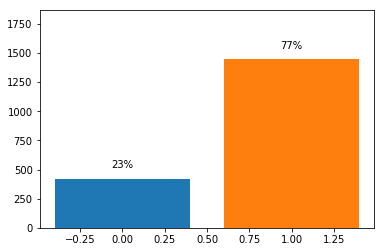

In [19]:
plt.close()
fig, ax = plt.subplots()
i = 0
for name, group in df.groupby('relevant'):
    s = group['id'].size
    plt.bar(i, s)
    plt.text(i, s + df['id'].size*0.05, "{:.0%}".format(s/df['id'].size),ha="center")
    i+=1
    
plt.ylim(0,df['id'].size)
#fig.tight_layout()
    
plt.show()

## Convolutional Neural Net

In [16]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=128)

Train on 1399 samples, validate on 466 samples
Epoch 1/10
1399/1399 [==============================] - 19s 14ms/step - loss: 0.6877 - acc: 0.7341 - val_loss: 0.6843 - val_acc: 0.7468
Epoch 2/10
1399/1399 [==============================] - 20s 14ms/step - loss: 0.6799 - acc: 0.7841 - val_loss: 0.6787 - val_acc: 0.7468
Epoch 3/10
1399/1399 [==============================] - 23s 17ms/step - loss: 0.6737 - acc: 0.7841 - val_loss: 0.6736 - val_acc: 0.7468
Epoch 4/10
1399/1399 [==============================] - 74s 53ms/step - loss: 0.6681 - acc: 0.7841 - val_loss: 0.6689 - val_acc: 0.7468
Epoch 5/10
1399/1399 [==============================] - 32s 23ms/step - loss: 0.6625 - acc: 0.7841 - val_loss: 0.6641 - val_acc: 0.7468
Epoch 6/10
1399/1399 [==============================] - 25s 18ms/step - loss: 0.6570 - acc: 0.7841 - val_loss: 0.6596 - val_acc: 0.7468
Epoch 7/10
1399/1399 [==============================] - 23s 16ms/step - loss: 0.6517 - acc: 0.7841 - val_loss: 0.6552 - val_acc: 0.7468
E

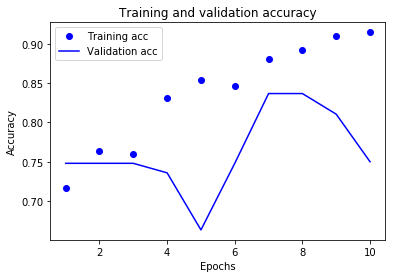

In [121]:
history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Recurrent neural network

In [20]:
def RNN():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    layer = LSTM(64)(embedded_sequences)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(2,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=sequence_input,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

# happy learning!
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1586)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1586, 300)         2153700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 2)                 514       
__________